In [98]:
import pandas as pd
import os
import re
from datetime import datetime, timedelta
import cv2
import numpy as np
import matplotlib.pyplot as plt
# from image_points import *
from read_positions import read_positions
from perspective import *
import random
%matplotlib inline
import random
from helper import *



In [99]:
df = read_positions(label_dir='../../data/labels', output_csv='positions.csv')
df = df[(df['Camera'] == 6) | (df['Camera'] == 6) | (df['Camera'] == 6)]
df.head(11)
len(df)

278

In [167]:
ELEPHANT_SIZE = 3
IMG_WIDTH, IMG_HEIGHT = 1920, 1000 
MAP_WIDTH_12, MAP_HEIGHT_12 = 856, 572
MAP_REAL_WIDTH_12 = 20

MAP_WIDTH_6, MAP_HEIGHT_6 = 1780, 1146
MAP_REAL_WIDTH_6 = 60


IMAGE_PTS_1 = np.array([[342, 272], [1346, 120], [1320, 396], [598, 410]])
MAP_PTS_1 = np.array([[179, 555],  [30, 243], [291, 292], [292, 458]])
H1, _ = cv2.findHomography(IMAGE_PTS_1, MAP_PTS_1)


IMAGE_PTS_2 = np.array([[35, 447], [1050, 299], [912, 405], [281, 513]])
MAP_PTS_2 = np.array([[695, 242],  [688, 552], [609, 463], [609, 291]])
H2, _ = cv2.findHomography(IMAGE_PTS_2, MAP_PTS_2)

IMAGE_PTS_6 = np.array([[1660, 660], [1394, 416], [414, 442], [248, 428], [600, 342]])
MAP_PTS_6 = np.array([ [1406, 224], [1126, 124], [882, 582], [726, 762], [190, 526]])

IMAGE_PTS_6 = np.array([[1394, 416], [414, 442], [248, 428], [600, 342]])
MAP_PTS_6 = np.array([[1126, 124], [882, 582], [726, 762], [190, 526]])

IMAGE_PTS_6 = np.array([[1394, 416], [1158, 326], [248, 428], [600, 342]])
MAP_PTS_6 = np.array([[1126, 124], [721, 65], [726, 782], [190, 526]])

H6, _ = cv2.findHomography(IMAGE_PTS_6, MAP_PTS_6)

CAMERA_to_H = {
    1: H1,
    2: H2,
    6: H6
}

CAMERA_to_MAP = {
    1: (MAP_WIDTH_12, MAP_HEIGHT_12),
    2: (MAP_WIDTH_12, MAP_HEIGHT_12),
    6: (MAP_WIDTH_6, MAP_HEIGHT_6)
}
# OPPOSING_CAMERA= {
#     1: 2,
#     2: 1,
# }
CAMERA_to_REAL = {
    1: MAP_REAL_WIDTH_12,
    2: MAP_REAL_WIDTH_12,
    6: MAP_REAL_WIDTH_6
}

def shift(x, y, width, height, camera):
    if camera in [1, 2, 6]:
        y += height/3
    else:
        y += height/2
    return x, y, width, height

In [153]:
def transform_row(M, x, y):

    def transform_point(M, x, y):
        points = np.array([[x, y]], dtype='float32')  
        points_reshaped = np.array([points])
        pointsOut = cv2.perspectiveTransform(points_reshaped, M)
        return pointsOut[0,0,0], pointsOut[0,0,1]

    x_proj, y_proj = transform_point(M, x, y)
    return x_proj, y_proj


def get_size(map_width_px, map_height_px, map_width_real):
    ratio = ELEPHANT_SIZE/map_width_real
    return ratio, ratio*map_width_px/map_height_px

In [154]:
# H, mask = cv2.findHomography(IMAGE_PTS_1, MAP_PTS_1)

df_proj = pd.DataFrame(columns=['Camera', 'Date', 'X_center', 'Y_center', 'Width', 'Height'])
for index, row in df.iterrows():
    data = {}
    data['Camera'] = row['Camera']
    map_width, map_height = CAMERA_to_MAP[data['Camera']]
    H = CAMERA_to_H[data['Camera']]
    width_real = CAMERA_to_REAL[data['Camera']]
    # print(width_real)
    data['Date'] = row['Date']
    x, y, width, height = row['X_center'], row['Y_center'], row['Width'], row['Height']
    
    x, y = x*IMG_WIDTH, y*IMG_HEIGHT
    width, height = width*IMG_WIDTH, height*IMG_HEIGHT
    # print(f'x, y, w, h = {x, y, width, height}')
    x, y, width, height = shift(x, y, width, height, data['Camera'])
        
    x_proj, y_proj = transform_row(H, x, y)
    # print(polygon)  
    data['X_center'], data['Y_center'] = x_proj/map_width, y_proj/map_height
    data['Width'], data['Height'] = get_size(map_width, map_height, width_real)
    
    # if data['Camera'] == 2 and random.random() > 0.35:
    #     continue
    df_proj = pd.concat([df_proj, pd.DataFrame([data])], ignore_index=True)
print(f'LEN = {len(df_proj)}')
df_proj.head()

LEN = 278


/tmp/ipykernel_1787313/4030764901.py:26: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_proj = pd.concat([df_proj, pd.DataFrame([data])], ignore_index=True)


Camera                Date  X_center  Y_center  Width    Height
0      6 2024-02-06 13:15:00 -0.111702  0.310923   0.05  0.077661
1      6 2024-02-06 13:15:00  0.065523  0.237617   0.05  0.077661
2      6 2024-01-29 13:15:00  0.647253  0.178063   0.05  0.077661
3      6 2024-01-29 13:15:00  0.679331  0.156091   0.05  0.077661
4      6 2024-01-29 13:15:00  0.669514  0.112890   0.05  0.077661

In [155]:
df_proj['Camera'].value_counts()

Camera
6    278
Name: count, dtype: int64

In [156]:
# def remove_duplicate_elephants(df, threshold=0.07):

#     def calculate_distance(row1, row2):
#         """Calculate the Euclidean distance between two points."""
#         return np.linalg.norm(np.array([row1['X_center'], row1['Y_center']]) - np.array([row2['X_center'], row2['Y_center']]))

    
#     # Prepare a list to track indices to remove
#     indices_to_remove = []

#     # Iterate through each unique timestamp
#     for timestamp in df['Date'].unique():
#         # Filter entries for this specific timestamp for both cameras
#         cam1_entries = df[(df['Camera'] == 1) & (df['Date'] == timestamp)]
#         cam2_entries = df[(df['Camera'] == 2) & (df['Date'] == timestamp)]
        
#         # Nested loop to calculate distances between all cam1 and cam2 entries
#         for index1, row1 in cam1_entries.iterrows():
#             for index2, row2 in cam2_entries.iterrows():
#                 distance = calculate_distance(row1, row2)
                
#                 # If distance is within threshold, check mutual closeness
#                 if distance < threshold:
#                     # Find closest cam2 entry to current cam1 entry
                    
#                     closest_to_cam1 = cam2_entries.apply(lambda row: calculate_distance(row, row1), axis=1).idxmin()
#                     # Find closest cam1 entry to current cam2 entry
#                     closest_to_cam2 = cam1_entries.apply(lambda row: calculate_distance(row, row2), axis=1).idxmin()
#                     # Check mutual closeness
#                     if closest_to_cam1 == index2 and closest_to_cam2 == index1:
#                         assert index2 not in indices_to_remove
#                         indices_to_remove.append(index2)  # Add cam2 entry to removal list
#                         c1 = (row1['X_center'], row1['Y_center'])
#                         c2 = (row2['X_center'], row2['Y_center'])
#                         # print(distance)
#                         c1 = (c1[0]*MAP_WIDTH_12, c1[1]*MAP_HEIGHT_12)
#                         c2 = (c2[0]*MAP_WIDTH_12, c2[1]*MAP_HEIGHT_12)


#     # Drop the entries from the original DataFrame
#     df_cleaned = df.drop(indices_to_remove)
    
#     return df_cleaned
    
# df_proj = remove_duplicate_elephants(df_proj)
# df_proj['Camera'].value_counts()


In [157]:
# def balance_camera_entries(df):
#     # Count the number of entries for each camera
#     cam1_count = df[df['Camera'] == 1].shape[0]
#     cam2_count = df[df['Camera'] == 2].shape[0]
    
#     # Determine which camera has more entries and compute the difference
#     if cam1_count > cam2_count:
#         more_entries_camera = 1
#         entries_to_remove = cam1_count - cam2_count
#     elif cam2_count > cam1_count:
#         more_entries_camera = 2
#         entries_to_remove = cam2_count - cam1_count
#     else:
#         # The dataset is already balanced
#         print("The dataset is already balanced.")
#         return df

#     # Randomly select indices of the camera with more entries to be deleted
#     indices_to_remove = np.random.choice(df[df['Camera'] == more_entries_camera].index, entries_to_remove, replace=False)
    
#     # Remove the selected indices
#     df_balanced = df.drop(indices_to_remove)
    
#     return df_balanced
# s
# # Example usage
# df_proj = balance_camera_entries(df_proj)
# df_proj['Camera'].value_counts()

In [158]:
def get_heatmap_new(df, camera, size):
    df = df[df['Camera'].isin(camera)]
    # print(df['Camera'])

    # Specify the dimensions of the heatmap
    heatmap_width, heatmap_height = size
    print(heatmap_width, heatmap_height)

    # Initialize a blank image for the heatmap
    heatmap_img = np.zeros((heatmap_height, heatmap_width), dtype=np.float32)

    # Function to apply intensity within the bounding box area
    def apply_bounded_gaussian_heatmap(cx, cy, w, h, heatmap):
        # Calculate the bounding box in pixel coordinates
        left = int(max(0, cx - w/2))
        right = int(min(heatmap_width, cx + w/2))
        top = int(max(0, cy - h/2))
        bottom = int(min(heatmap_height, cy + h/2))

        sigma_x = w / 6
        sigma_y = h / 6

        # Apply intensity only within the bounding box, using a Gaussian distribution
        for y in range(top, bottom):
            for x in range(left, right):
                dx = cx - x
                dy = cy - y
                value = np.exp(-(dx ** 2 / (2 * sigma_x ** 2) + dy ** 2 / (2 * sigma_y ** 2)))
                heatmap[y, x] += value

    # Populate the heatmap with bounded Gaussian distribution
    for index, row in df.iterrows():
        cx, cy, w, h = row['X_center'] * heatmap_width, row['Y_center'] * heatmap_height, row['Width'] * heatmap_width, row['Height'] * heatmap_height
        apply_bounded_gaussian_heatmap(cx, cy, w, h, heatmap_img)

    # Normalize the heatmap
    cv2.normalize(heatmap_img, heatmap_img, 0, 255, norm_type=cv2.NORM_MINMAX)
    zero_mask = (heatmap_img < 20)
    # Apply a colormap to create a color heatmap
    heatmap_color = cv2.applyColorMap(np.uint8(heatmap_img), cv2.COLORMAP_JET)
    heatmap_color[zero_mask] = (0,0,0)
    # plt.figure()
    # plt.imshow(heatmap_color[..., ::-1])  # change channels order since the YOLO work on BGR images
    # plt.show()
    return heatmap_color


In [159]:
# # Optionally, load an actual image to overlay the heatmap on
# original_img = cv2.imread('back.jpeg')
# heatmap_color = get_heatmap_new(df_balanced, [1, 2])
# overlayed_img = cv2.addWeighted(original_img, 0.8, heatmap_color, 1, 0)
# plt.figure()
# plt.imshow(overlayed_img[..., ::-1])  # change channels order since the YOLO work on BGR images
# plt.show()
# xx

1780 1146


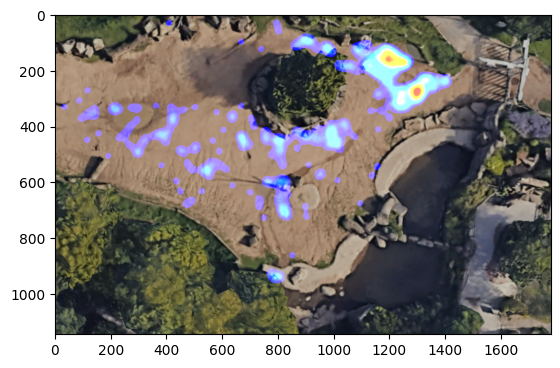

In [160]:
# Optionally, load an actual image to overlay the heatmap on
original_img = cv2.imread('maps/map6_real.png')
heatmap_color = get_heatmap_new(df_proj[:], [6], CAMERA_to_MAP[6])
overlayed_img = cv2.addWeighted(original_img, 0.8, heatmap_color, 1, 0)
plt.figure()
plt.imshow(overlayed_img[..., ::-1])  # change channels order since the YOLO work on BGR images
plt.show()


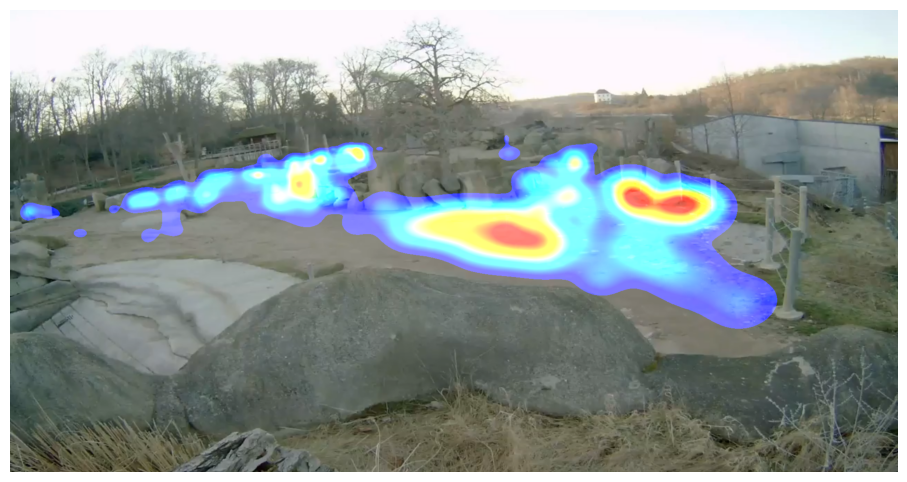

In [161]:
heat = cv2.imread('heat/heat6.png')
plot_images(heat)

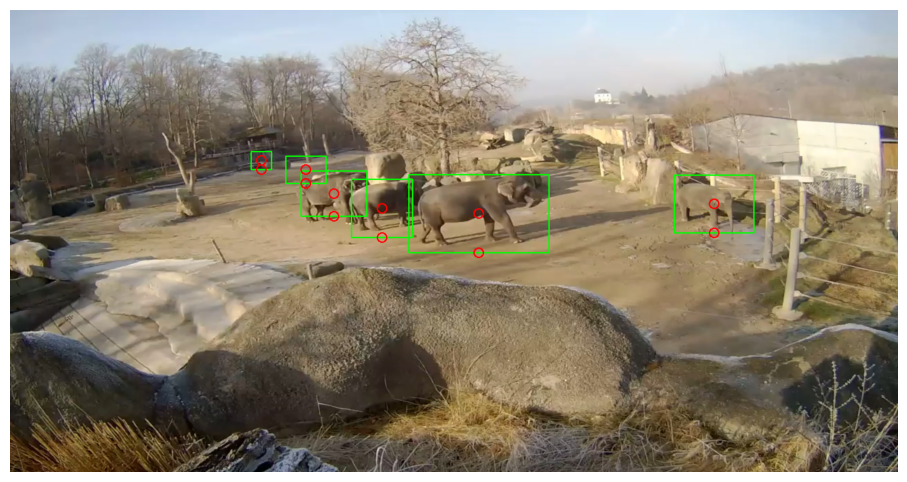

In [172]:
# H, mask = cv2.findHomography(IMAGE_PTS_1, MAP_PTS_1)

#df_x = pd.DataFrame(columns=['Camera', 'Date', 'X_center', 'Y_center', 'Width', 'Height'])
background = cv2.imread('../../data/images/screenshot6_29_01__11_45.png')
for index, row in df[9:15].iterrows():
    data = {}
    data['Camera'] = row['Camera']
    map_width, map_height = CAMERA_to_MAP[data['Camera']]
    H = CAMERA_to_H[data['Camera']]
    width_real = CAMERA_to_REAL[data['Camera']]
    # print(width_real)
    data['Date'] = row['Date']
    x, y, width, height = row['X_center'], row['Y_center'], row['Width'], row['Height']
    
    x, y = x*IMG_WIDTH, y*IMG_HEIGHT
    width, height = width*IMG_WIDTH, height*IMG_HEIGHT
    # print(f'x, y, w, h = {x, y, width, height}')
    x, y, width, height = shift(x, y, width, height, data['Camera'])
    plot_rectangle_on_image(background, x, y-height/2, width, height)
    draw_circle(background, x, y)
    draw_circle(background, x, y-height/2)
        
    x_proj, y_proj = transform_row(H, x, y)
    # print(polygon)  
    # data['X_center'], data['Y_center'] = x_proj/map_width, y_proj/map_height
    # data['Width'], data['Height'] = get_size(map_width, map_height, width_real)
    
    # if data['Camera'] == 2 and random.random() > 0.35:
    #     continue
plot_images(background)

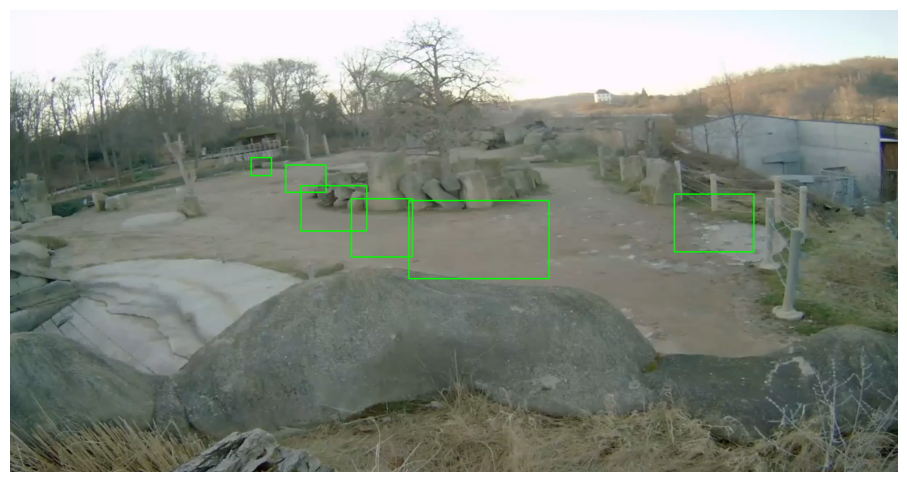

In [163]:
plot_images(background)

In [164]:
df[10:15]

Camera                Date  X_center  Y_center     Width  Height
93        6 2024-01-29 12:45:00  0.418750    0.4290  0.068750   0.126
94        6 2024-01-29 12:45:00  0.527865    0.4405  0.157812   0.169
95        6 2024-01-29 12:45:00  0.793229    0.4195  0.089583   0.125
127       6 2024-02-06 13:00:00  0.333073    0.3455  0.045312   0.059
128       6 2024-02-06 13:00:00  0.283333    0.3255  0.022917   0.039

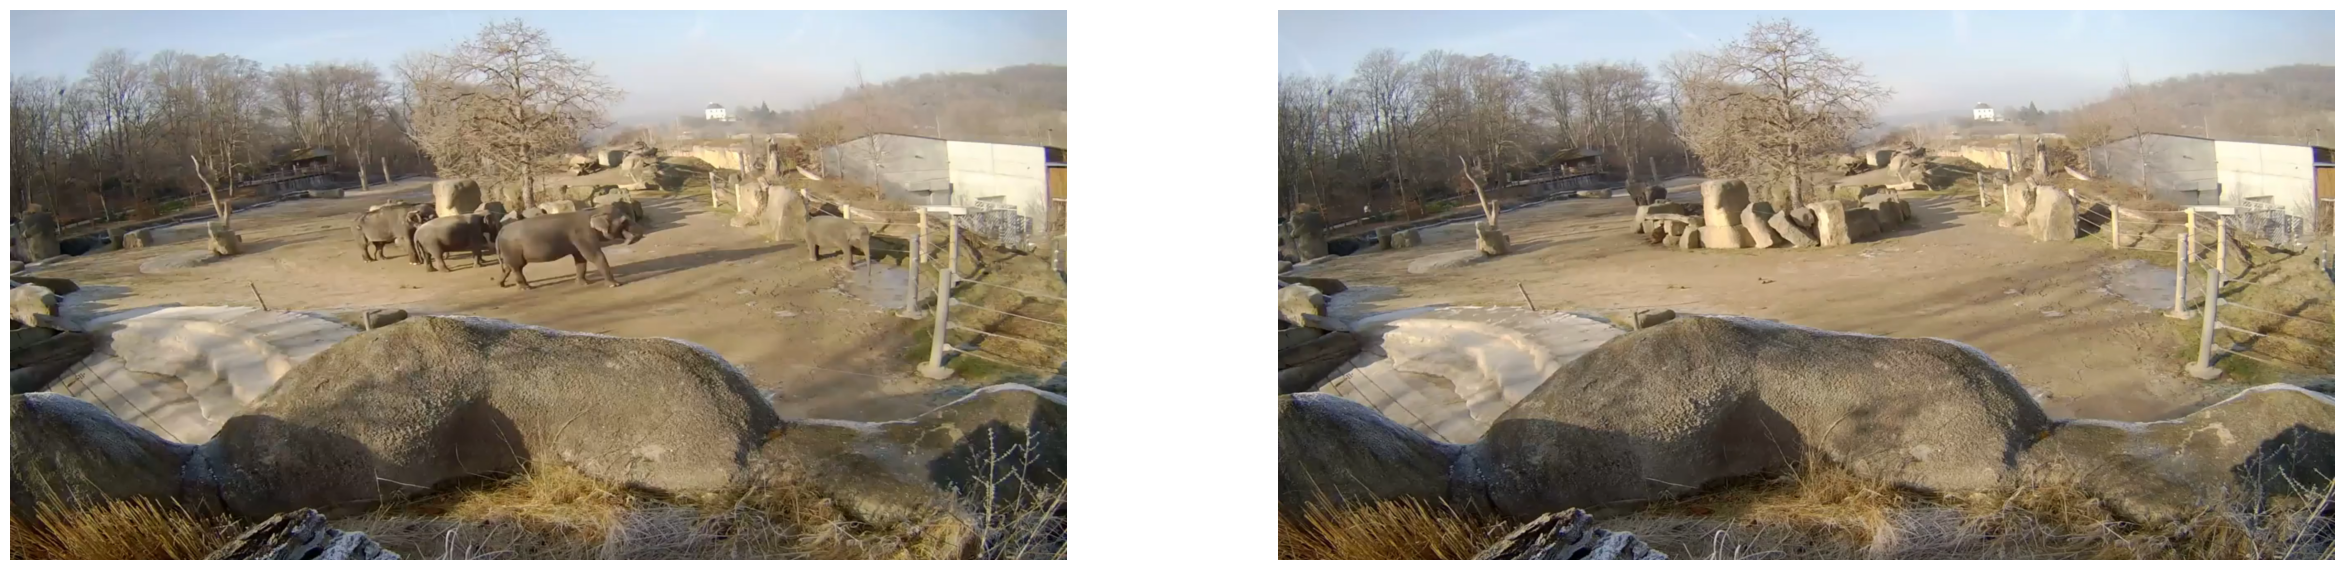

In [165]:
x = cv2.imread('../../data/images/screenshot6_29_01__11_45.png')
y = cv2.imread('../../data/images/screenshot6_29_01__12_00.png')

plot_images(x, y)
